In [1]:
import wrds
import pandas_datareader
import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
from decimal import Decimal
import scipy
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

In [2]:
load_data = False
data_folder = '/Users/Xinlin/Desktop/Quantitative Asset Management/Problem Sets/PS3/'
wrds_id = 'yxinlin'

min_shrcd = 10
max_shrcd = 11
min_year = 1926
max_year = 2021
possible_exchcd = (1, 2, 3)

if load_data:
    conn = wrds.Connection(wrds_username=wrds_id)
    # load CRSP returns
    crsp_raw = conn.raw_sql("""
                          select a.permno, a.date, a.ret, a.shrout, a.prc,
                          b.shrcd, b.exchcd
                          from crspq.msf as a
                          left join crspq.msenames as b
                          on a.permno=b.permno
                          and b.namedt<=a.date
                          and a.date<=b.nameendt
                          where b.shrcd between """ + str(min_shrcd) + """ and  """ + str(max_shrcd) + """
                          and a.date between '01/01/""" +str(min_year)+ """' and '12/31/""" +str(max_year)+ """'
                          and b.exchcd in """ + str(possible_exchcd) + """
                          """)
    # load CRSP delisting returns
    dlret_raw = conn.raw_sql("""
                            select permno, dlstdt, dlret, dlstcd
                            from crspq.msedelist
                            """)
    conn.close()
    
    # save csv
    crsp_raw.to_csv('crsp_raw.csv')
    dlret_raw.to_csv('dlret_raw.csv')

else:
    crsp_raw = pd.read_csv('crsp_raw.csv')
    dlret_raw = pd.read_csv('dlret_raw.csv')                      

In [3]:
## data cleaning
# change variables
crsp_raw['permno'] = crsp_raw['permno'].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'], format='%Y-%m-%d', errors='ignore')
crsp_raw['date'] = pd.DataFrame(crsp_raw[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
crsp_raw = crsp_raw.sort_values(by=['date', 'permno'])

dlret_raw.permno = dlret_raw.permno.astype(int)
dlret_raw['date'] = pd.to_datetime(dlret_raw['dlstdt'], format='%Y-%m-%d', errors='ignore')
dlret_raw['date'] = pd.DataFrame(dlret_raw[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
dlret_raw = dlret_raw.sort_values(by=['date', 'permno'])

# merge holding period return data with delisted return data
crsp = crsp_raw.merge(dlret_raw, how='outer', on=['date', 'permno'])

# compute adjusted returns
crsp['ret'] = np.where(crsp['ret'].notna() & crsp['dlret'].notna(), 
                       (1+crsp['ret'])*(1+crsp['dlret'])-1, crsp['ret'])
crsp['ret'] = np.where(crsp['ret'].isna() & crsp['dlret'].notna(),
                       crsp['dlret'], crsp['ret'])
crsp = crsp[crsp['ret'].notna()]

# final input
crsp = crsp[['date','permno','exchcd','prc','shrout','ret']].\
              sort_values(by=['date','permno']).reset_index(drop=True)
crsp_stocks = crsp.copy()

In [4]:
#load Fama-French Data
load_data = False

if load_data:
    # F-F 3 Factors
    pd.set_option('precision', 4)
    ff3 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', start='1926', end='2022')
    ff3 = ff3.read()[0]/100
    ff3.columns = 'MktRF', 'SMB', 'HML', 'RF'
    ff3['Mkt'] = ff3['MktRF'] + ff3['RF']
    ff3.to_csv('ff3.csv')
    
    # F-F Momentum Factors
    ff_m = pandas_datareader.famafrench.FamaFrenchReader('F-F_Momentum_Factor',start='1926',end='2022')
    ff_m = ff_m.read()[0]/100
    ff_m.rename(columns={'Mom':'UMD'}, inplace=True)
    ff_m.to_csv('ff_m.csv')
    
    # F-F Momentum Portfolios
    ff_p = pandas_datareader.famafrench.FamaFrenchReader('10_Portfolios_Prior_12_2',start='1926',end='2022')
    ff_p = ff_p.read()[0]/100
    ff_p.columns = 'M01','M02','M03','M04','M05','M06','M07','M08','M09','M10'
    ff_p.to_csv('ff_p.csv')

else:
    ff3 = pd.read_csv('ff3.csv')
    ff_m = pd.read_csv('ff_m.csv')
    ff_p = pd.read_csv('ff_p.csv')

In [5]:
ff3['date'] = pd.to_datetime(ff3['Date'], format='%Y-%m-%d', errors='ignore')
ff3['date'] = pd.DataFrame(ff3[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)

### Question 1: Using CRSP stock data, define the universe of monthly returns that can be used in calculating momentum portfolios, as well as their ranking return, following the procedure in Daniel and Moskowitz (2016).

In [6]:
# compute mkt_cap
crsp['me'] = crsp['prc'].abs() * crsp['shrout']

# find lag_mkt_cap
crsp['new_date'] = crsp['date'] + dt.timedelta(days=20)
crsp['new_date'] = pd.DataFrame(crsp[['new_date']].values.astype('datetime64[ns]')) + MonthEnd(0)
lcrsp = crsp[['new_date','permno','me']].rename(columns={'new_date':'date', 'me':'lag_mkt_cap'})
crsp = crsp[['date','permno','exchcd','ret','me']]
crsp = crsp.merge(lcrsp, how='inner', on=['date','permno'])
crsp = crsp[crsp['ret'].notna() & crsp['lag_mkt_cap'].notna()]
crsp = crsp.drop_duplicates(subset=['date','permno'])

In [7]:
# compute past returns: cumulative log return (t-12 ~ t-2)
df = crsp.sort_values(by=['permno','date'])
df = df.loc[df['lag_mkt_cap']>0]
df['log_ret'] = np.log(1 + df['ret'].shift(1))  # log return (lag 1 month)
df_ret = df.groupby(['permno']).rolling(window=11, on='date')['log_ret'].sum().reset_index()\
         .rename(columns={'log_ret':'ret12m'}).dropna()

In [8]:
# find ranking returns
df = pd.merge(df, df_ret, how='left', on=['permno','date'])
df = df[df['date']>=pd.to_datetime('1927-01-01')]
df = df[df['ret12m'].notna()]
df = df.sort_values('date')
ranking_ret = df.groupby('date')['ret12m'].rank(method='max')\
              .reset_index().rename(columns={'ret12m':'ranking_ret'})

In [9]:
df = df.reset_index()
df = pd.merge(df, ranking_ret, how='left', on=['index']).reset_index(drop=True)
q1 = df[['date','permno','lag_mkt_cap','ret12m','ranking_ret']]
q1

,date,permno,lag_mkt_cap,ret12m,ranking_ret
0,1927-01-31,10057,3.062500e+03,-0.656780,37.0
1,1927-01-31,13741,1.450000e+04,-0.115012,168.0
2,1927-01-31,13733,1.506560e+05,-0.020845,218.0
3,1927-01-31,11586,1.060000e+04,0.131534,334.0
4,1927-01-31,13717,6.125000e+03,0.283627,409.0
...,...,...,...,...,...
3344098,2022-01-31,90011,2.484273e+06,0.010690,4.0
3344099,2022-01-31,89913,2.799653e+05,0.518558,9.0
3344100,2022-01-31,89270,2.646561e+05,0.526234,10.0
3344101,2022-01-31,17154,5.196150e+04,-2.840161,1.0


### Question 2: Define the monthly momentum portfolio decile of each stock as defined by Daniel & Moskowitz (2016) and Kenneth R. French.

In [10]:
# find Daniel & Moskowitz portfolio decile of each stock
K = 10 # number of percentile
s = 'ret12m' # signal

df['DM_decile'] = np.nan
df['DM_decile'] = df.groupby('date')[s].transform(lambda x: pd.qcut(x, K, labels=np.arange(1,K+1)))
df['DM_decile'] = df['DM_decile'].astype('float')

In [11]:
# find Kenneth R. French's portfolio decile of each stock
def bins(df,K,s,use_cutoff_flag=False):
    df = df.copy()
    
    # Defining the momentum percentiles
    df['brkpts_flag'] = True
    if use_cutoff_flag:
        df['brkpts_flag'] = (df['exchcd'] == 1)

    def diff_brkpts(x,K):
        brkpts_flag = x['brkpts_flag']
        x = x[s]
        loc_nyse = x.notna() & brkpts_flag  
        if np.sum(loc_nyse) > 0:
            breakpoints = pd.qcut(x[loc_nyse], K, retbins=True, labels=False)[1]
            breakpoints[0] = -np.inf
            breakpoints[K] = np.inf
            y = pd.cut(x, bins=breakpoints, labels=False) + 1
        else:
            y = x + np.nan
        return y

    df['KRF_decile'] = df.groupby('date').apply(lambda x:diff_brkpts(x,K)).reset_index()[s]
    df.drop('brkpts_flag',axis=1,inplace=True)
    return df

df = bins(df,K,s,use_cutoff_flag=True)

In [12]:
df = df[df['date']<=pd.to_datetime('2021-12-31')]
q2 = df[['date','permno','lag_mkt_cap','ret12m','DM_decile','KRF_decile']]
q2

,date,permno,lag_mkt_cap,ret12m,DM_decile,KRF_decile
0,1927-01-31,10057,3.062500e+03,-0.656780,1.0,1.0
1,1927-01-31,13741,1.450000e+04,-0.115012,4.0,4.0
2,1927-01-31,13733,1.506560e+05,-0.020845,5.0,5.0
3,1927-01-31,11586,1.060000e+04,0.131534,8.0,8.0
4,1927-01-31,13717,6.125000e+03,0.283627,10.0,10.0
...,...,...,...,...,...,...
3344086,2021-12-31,14682,3.492788e+05,-0.173769,3.0,2.0
3344087,2021-12-31,52708,2.855805e+07,0.330967,8.0,8.0
3344088,2021-12-31,14653,7.602386e+05,0.242935,7.0,7.0
3344089,2021-12-31,46886,6.188149e+07,0.466482,9.0,9.0


### Question 3: Calculate the monthly momentum portfolio decile returns.

In [13]:
# compute value-weighted returns for each decile
sum_mv_dm = df.groupby(['date', 'DM_decile'])['lag_mkt_cap'].sum().reset_index()\
         .rename(columns={'lag_mkt_cap': 'sum_mv_dm'})
sum_mv_krf = df.groupby(['date', 'KRF_decile'])['lag_mkt_cap'].sum().reset_index()\
         .rename(columns={'lag_mkt_cap': 'sum_mv_krf'})
df = pd.merge(df, sum_mv_dm, how='left', on=['date','DM_decile'])
df = pd.merge(df, sum_mv_krf, how='left', on=['date','KRF_decile'])

df['vw_DM_ret'] = (df['lag_mkt_cap']/df['sum_mv_dm']) * df['ret']
df['vw_KRF_ret'] = (df['lag_mkt_cap']/df['sum_mv_krf']) * df['ret']

DM_ret = df.groupby(['date', 'DM_decile'])['vw_DM_ret'].sum().reset_index()\
         .rename(columns={'vw_DM_ret': 'DM_ret'})
KRF_ret = df.groupby(['date', 'KRF_decile'])['vw_KRF_ret'].sum().reset_index()\
         .rename(columns={'vw_KRF_ret': 'KRF_ret', 'KRF_decile':'DM_decile'})

In [14]:
q3 = pd.merge(DM_ret, KRF_ret, how='left', on=['date','DM_decile']).rename(columns={'DM_decile':'decile'})
q3 = pd.merge(q3, ff3[['RF','date']], how='left', on=['date'])
q3

,date,decile,DM_ret,KRF_ret,RF
0,1927-01-31,1.0,-0.041315,-0.042515,0.0025
1,1927-01-31,2.0,-0.027646,-0.026722,0.0025
2,1927-01-31,3.0,0.013340,0.013264,0.0025
3,1927-01-31,4.0,0.000598,-0.003102,0.0025
4,1927-01-31,5.0,-0.004913,-0.003343,0.0025
...,...,...,...,...,...
11395,2021-12-31,6.0,0.055837,0.057135,0.0001
11396,2021-12-31,7.0,0.057971,0.039416,0.0001
11397,2021-12-31,8.0,0.030951,0.035495,0.0001
11398,2021-12-31,9.0,0.014019,0.011353,0.0001


### Question 4: Replicate Table 1 in Daniel and Moskowitz (2016)

In [15]:
q4 = q3.drop('KRF_ret', axis=1)
q4['ex_ret'] = q4['DM_ret'] - q4['RF']
q4['log_ret'] = np.log(q4['DM_ret'] + 1)

# compute annualized mean excess return
ex_ret = q4.groupby('decile')['ex_ret'].mean().reset_index()
ex_ret['annualized_ex_ret'] = ex_ret['ex_ret']*12*100

# compute annualized standard deviation of return
std = q4.groupby('decile')['ex_ret'].std().reset_index()
std['annualized_std'] = std['ex_ret']*np.sqrt(12)*100

# compute annualized Sharpe Ratio
table = pd.merge(ex_ret, std, how='left', on=['decile'])
table['sharpe_ratio'] = table['annualized_ex_ret']/table['annualized_std']

# compute skewness of log return
from scipy.stats import skew
sk = q4.groupby('decile')['log_ret'].skew().reset_index().rename(columns={'log_ret':'skewness_logret'})

table = pd.merge(table, sk, how='left', on=['decile']).drop(['ex_ret_x','ex_ret_y'], axis=1)

In [16]:
# compute statistics for WML portfolio
q4['WML_long'] = np.where(q4['decile']==10, 1, 0)
q4['WML_short'] = np.where(q4['decile']==1, -1, 0)
q4['WML_ret'] = q4['WML_long']*q4['DM_ret'] + q4['WML_short']*q4['DM_ret']
wml = q4.groupby('date')['WML_ret'].sum().reset_index()
wml = pd.merge(wml, ff3[['date','RF']], how='left', on=['date'])
wml['WML_log_ret'] = np.log(1 + wml['WML_ret'] + wml['RF'])

wml_ret = np.mean(wml['WML_ret'])*12*100
wml_std = np.std(wml['WML_ret'])*np.sqrt(12)*100
wml_sr = wml_ret/wml_std
wml_sk = wml['WML_log_ret'].skew()

In [17]:
# replication
table.loc[len(table.index)] = ('WML', wml_ret, wml_std, wml_sr, wml_sk)
table.set_index('decile').transpose()

decile,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,WML
annualized_ex_ret,4.911802,5.236098,7.717707,7.961146,7.788744,8.166412,8.894326,10.698912,10.107368,13.913351,9.001549
annualized_std,38.731692,30.606829,26.773714,22.486802,20.833927,19.713101,19.198477,19.190952,19.481140,23.572195,31.746588
sharpe_ratio,0.126816,0.171076,0.288257,0.354036,0.373849,0.414263,0.463283,0.557498,0.518828,0.590244,0.283544
skewness_logret,-0.138470,-0.316702,0.033885,-0.186708,-0.281644,-0.241080,-0.539296,-0.327111,-0.711772,-0.728063,-6.271649


### Question 5: Calculate the correlation of your portfolio returns with Daniel & Moskowitz (2016) and Kenneth R. French

In [18]:
# load Kent Daniel Data
dm = pd.read_csv('m_m_pt_tot.txt', sep='\s+', header=None)
dm.columns = 'date', 'decile', 'ret','a','b'
dm['date'] = pd.to_datetime(dm['date'], format='%Y%m%d', errors='ignore')
dm = dm[['date','decile','ret']]
DM_returns = pd.merge(dm, q3[['date','decile','DM_ret']], how='left', on=['date','decile']).dropna()

# compute decile portfolio correlation
dm_cor = DM_returns.groupby('decile')[['DM_ret','ret']].corr(method='pearson', min_periods=1).reset_index()
dm_cor = dm_cor[['decile','ret']].rename(columns={'ret':'DM_corr'})
dm_cor = dm_cor[dm_cor['DM_corr'] != 1].reset_index(drop=True)

# compute Daniel WML portfolio correlation
dm['WML_long'] = np.where(dm['decile']==10, 1, 0)
dm['WML_short'] = np.where(dm['decile']==1, -1, 0)
dm['dm_WML_ret'] = dm['WML_long']*dm['ret'] + dm['WML_short']*dm['ret']
dm_wml = dm.groupby('date')['dm_WML_ret'].sum().reset_index()
dm_wml = pd.merge(dm_wml, wml[['date','WML_ret']], how='left', on=['date'])
dm_wml_corr = dm_wml[['dm_WML_ret','WML_ret']].corr(method='pearson', min_periods=1)
dm_wml_corr = dm_wml_corr['WML_ret'][0]
dm_cor.loc[len(dm_cor.index)] = ('WML', dm_wml_corr)

In [19]:
# load FF data
ff_p.columns = 'date','M1','M2','M3','M4','M5','M6','M7','M8','M9','M10'
ff_p['date'] = pd.DataFrame(ff_p[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
ff_p['WML'] = ff_p['M10'] - ff_p['M1']
ff_p.drop(index=ff_p.index[-1],axis=0, inplace=True)
ff_p = ff_p.set_index('date')

# compute correlation with French's data
KRF_returns = q3[['date','decile','KRF_ret']]
KRF_returns = pd.pivot(KRF_returns, index='date', columns='decile')
KRF_returns = KRF_returns['KRF_ret']
KRF_returns.columns = 'M1','M2','M3','M4','M5','M6','M7','M8','M9','M10'
KRF_returns['WML'] = KRF_returns['M10'] - KRF_returns['M1']
KRF_corr = KRF_returns.corrwith(ff_p, axis=0, method='pearson')

In [20]:
# final output
KRF_cor = [KRF_corr['M1'],KRF_corr['M2'],KRF_corr['M3'],KRF_corr['M4'],KRF_corr['M5'],KRF_corr['M6'],\
            KRF_corr['M7'],KRF_corr['M8'],KRF_corr['M9'],KRF_corr['M10'],KRF_corr['WML']]
dm_cor['KRF_corr'] = KRF_cor
corr = dm_cor.set_index('decile')
corr.transpose()

decile,1,2,3,4,5,6,7,8,9,10,WML
DM_corr,0.966979,0.966542,0.961300,0.954831,0.967377,0.962954,0.963227,0.960611,0.959836,0.972565,0.927431
KRF_corr,0.971103,0.969439,0.963711,0.945371,0.955776,0.958633,0.957176,0.949192,0.956781,0.973120,0.928174


### Question 6: Has the momentum anomaly worked in the past few years?

In [21]:
# historical performance in past 5 years
q6 = q3[q3['date']>=pd.to_datetime('2017-01-31')]
losers = q6[q6['decile']==1].rename(columns={'DM_ret':'losers_ret'})
winners = q6[q6['decile']==10].rename(columns={'DM_ret':'winners_ret'})
q6 = pd.merge(winners[['date','winners_ret']], losers[['date','losers_ret','RF']], how='left', on=['date'])
q6['WML'] = (q6['winners_ret']-q6['losers_ret']+1).cumprod()
q6['winners'] = (q6['winners_ret']+1).cumprod()
q6['losers'] = (q6['losers_ret']+1).cumprod()
q6['risk_free'] = (q6['RF']+1).cumprod()

<AxesSubplot: xlabel='date', ylabel='winners'>

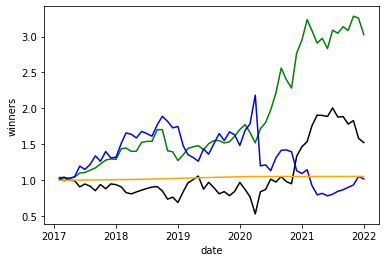

In [22]:
plt.figure(1)
sns.lineplot(x=q6['date'], y=q6['winners'], color='green')
sns.lineplot(x=q6['date'], y=q6['losers'], color='black')
sns.lineplot(x=q6['date'], y=q6['WML'], color='blue')
sns.lineplot(x=q6['date'], y=q6['risk_free'], color='orange')